In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# load in the t0s
t0s = np.genfromtxt('t0s_all.txt', delimiter=',')
if t0s.ndim == 0:
    t0s = np.array([t0s])
    
    
period = 160.884
duration = 10.7536
# # now to plot!

In [16]:
def determine_cadence(times):
    time_gaps = {}
    for ii in range(1, len(times)):
        time_gap = np.round(times[ii]-times[ii-1], 4)
        if time_gap in time_gaps.keys():
            time_gaps[time_gap] += 1
        else:
            time_gaps[time_gap] = 1
            
    #find the key that corresponds to the most data gaps, this is the cadence
    cadence = max(time_gaps, key=time_gaps.get)
    return cadence
            
        

In [20]:
kepler_mm = pd.read_csv('mm_kipping_kepler.dat', delimiter='\t', header=None, names=['time', 'flux', 'flux_err'])
baro_mm = pd.read_csv('mm_kipping_baro.dat', delimiter='\t', header=None, names=['time', 'flux', 'flux_err'])
baron_mm = pd.read_csv('mm_kipping_baron.dat', delimiter='\t', header=None, names=['time', 'flux', 'flux_err'])
tess_mm = pd.read_csv('mm_kipping_tess.dat', delimiter=' ', header=None, names=['time', 'flux', 'flux_err'])


x_kepler_mm, y_kepler_mm, yerr_kepler_mm = kepler_mm['time']+2400000-2454833, kepler_mm['flux']-1, kepler_mm['flux_err']
x_baro_mm, y_baro_mm, yerr_baro_mm = baro_mm['time']+2400000-2454833, baro_mm['flux']-1, baro_mm['flux_err']
x_baron_mm, y_baron_mm, yerr_baron_mm = baron_mm['time']+2400000-2454833, baron_mm['flux']-1, baron_mm['flux_err']
x_tess_mm, y_tess_mm, yerr_tess_mm = tess_mm['time']+2400000-2454833, tess_mm['flux']-1, tess_mm['flux_err']



x = np.concatenate((x_kepler_mm.values, x_baro_mm.values, x_baron_mm.values, x_tess_mm.values))
y = np.concatenate((y_kepler_mm.values, y_baro_mm.values, y_baron_mm.values, y_tess_mm.values))
yerr = np.concatenate((yerr_kepler_mm.values, yerr_baro_mm.values, yerr_baron_mm.values, yerr_tess_mm.values))


In [21]:
from collections import OrderedDict

texp_kepler = determine_cadence(x_kepler_mm.values)
texp_baro = determine_cadence(x_baro_mm.values)
texp_baron = determine_cadence(x_baron_mm.values)
texp_tess = determine_cadence(x_tess_mm.values)


datasets = OrderedDict(
    [
        ("Kepler", [x_kepler_mm.values, y_kepler_mm.values, yerr_kepler_mm.values, texp_kepler]),
        ("BARO", [x_baro_mm.values, y_baro_mm.values, yerr_baro_mm.values, texp_baro]),
        ("BARON", [x_baron_mm.values, y_baron_mm.values, yerr_baron_mm.values, texp_baron]),
        ("TESS", [x_tess_mm.values, y_tess_mm.values, yerr_tess_mm.values, texp_tess]),
    ]
)

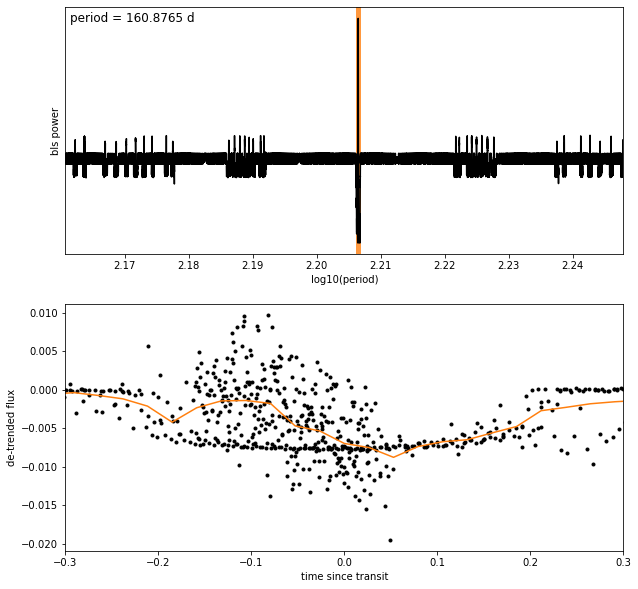

In [22]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(period-.1*period), np.log(period+.1*period), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold, y, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux")
_ = ax.set_xlabel("time since transit")

In [23]:
import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as xo
import aesara_theano_fallback.tensor as tt
from functools import partial
from celerite2.theano import terms, GaussianProcess



# Find a reference transit time near the middle of the observations to avoid
# strong covariances between period and t0
x_min = min(np.min(x) for x, _, _, _ in datasets.values())
x_max = max(np.max(x) for x, _, _, _ in datasets.values())
x_mid = 0.5 * (x_min + x_max)

mid_epoch = np.round((x_mid) / bls_period)
t0_ref = bls_period * np.round((x_mid - t0s[0]) / bls_period)

trans_inds = [0,1,3,4,5,6,7,8,29]


with pm.Model() as model:

    # Shared orbital parameters --> impact parameter, transit times, stellar density
    ###########################
    ###########################
    ###########################
    #stellar density
    log_rho_star = pm.Uniform('log_rho_star', lower=-3, upper=3)
    rho_star = pm.Deterministic('rho_star', tt.exp(log_rho_star))
    
    # impact parameter
    b = pmx.UnitUniform("b")
    #ld_arg = 1 - tt.sqrt(1 - b**2)
    
    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(1):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=t0s,
                sd=1.0,
                shape=len(t0s),
            )
        )

        
    # Now we have a parameter for each transit time for each planet:
    transit_inds = pm.Deterministic("transit_inds", tt.constant(trans_inds))
    
    
    
    
    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times, 
                               rho_star=rho_star, transit_inds=[transit_inds])
    
    

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0 + orbit.period * mid_epoch)
    pm.Deterministic("period", orbit.period)
    pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])
    
    




    # not shared parameters --> depth and limb-darkening
    # Loop over the instruments
    parameters = dict()
    lc_models = dict()
    for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):

        # We define the per-instrument parameters in a submodel so that we
        # don't have to prefix the names manually
        with pm.Model(name=name, model=model):
            # The limb darkening
            u = xo.QuadLimbDark("u")
            star = xo.LimbDarkLightCurve(u)

            # The radius ratio
            #log_approx_depth = pm.Normal(
            #    "log_approx_depth", mu=np.log(4e-3), sigma=10
            #)
            #ld = 1 - u[0] * ld_arg - u[1] * ld_arg**2
            #ror = pm.Deterministic(
            #    "ror", tt.exp(0.5 * log_approx_depth) / tt.sqrt(ld)
            #)
            
            
            #rp_over_rstar 
            ror = pm.Uniform('ror', lower=0, upper=1, testval=(np.sqrt(bls_depth)))
    
            

            # Noise parameters
            med_yerr = np.median(yerr)
            std = np.std(y)
            sigma = pm.InverseGamma(
                "sigma",
                testval=med_yerr,
                **pmx.estimate_inverse_gamma_parameters(
                    med_yerr, 0.5 * std
                ),
            )
            

            # Keep track of the parameters for optimization
            parameters[name] = [u, ror]
            parameters[f"{name}_noise"] = [sigma]

        # The light curve model
        def lc_model(star, ror, texp, t):
            return pm.math.sum(
                star.get_light_curve(orbit=orbit, r=ror, t=t, texp=texp),
                axis=-1,
            )

        lc_model_partial = partial(lc_model, star, ror, texp)
        lc_models[name] = lc_model_partial
        
        lc_model_obs = lc_model(star, ror, texp, x)
        pm.Normal(f"{name}_obs", mu=lc_model_obs, sd=np.sqrt(yerr**2.), observed=y)



    # Optimize the model
    map_soln = model.test_point
    for name in datasets:
        map_soln = pmx.optimize(map_soln, parameters[name])
    for name in datasets:
        map_soln = pmx.optimize(map_soln, parameters[f"{name}_noise"])
        map_soln = pmx.optimize(map_soln, parameters[name] + [b])
    map_soln = pmx.optimize(map_soln)

optimizing logp for variables: [Kepler_ror, Kepler_u]


message: Desired error not necessarily achieved due to precision loss.
logp: 27268.633321721692 -> 31252.535580833086
optimizing logp for variables: [BARO_ror, BARO_u]


message: Optimization terminated successfully.
logp: 31252.535580833086 -> 31254.730614893742


optimizing logp for variables: [BARON_ror, BARON_u]


message: Optimization terminated successfully.
logp: 31254.730614893742 -> 31256.698666073746


optimizing logp for variables: [TESS_ror, TESS_u]


message: Optimization terminated successfully.
logp: 31256.698666073746 -> 31258.797073668207


optimizing logp for variables: [Kepler_sigma]


message: Optimization terminated successfully.
logp: 31258.797073668207 -> 31261.183503315304


optimizing logp for variables: [b, Kepler_ror, Kepler_u]


message: Desired error not necessarily achieved due to precision loss.
logp: 31261.183503315304 -> 31863.631260415408
optimizing logp for variables: [BARO_sigma]


message: Optimization terminated successfully.
logp: 31863.631260415408 -> 31866.43630445203


optimizing logp for variables: [b, BARO_ror, BARO_u]


message: Optimization terminated successfully.
logp: 31866.43630445203 -> 31866.866576424014
optimizing logp for variables: [BARON_sigma]


message: Optimization terminated successfully.
logp: 31866.866576424014 -> 31869.661697457952
optimizing logp for variables: [b, BARON_ror, BARON_u]


message: Optimization terminated successfully.
logp: 31869.661697457952 -> 31870.584210595374
optimizing logp for variables: [TESS_sigma]


message: Optimization terminated successfully.
logp: 31870.584210595374 -> 31873.378062717027


optimizing logp for variables: [b, TESS_ror, TESS_u]


message: Optimization terminated successfully.
logp: 31873.378062717027 -> 31873.935667468795


optimizing logp for variables: [TESS_sigma, TESS_ror, TESS_u, BARON_sigma, BARON_ror, BARON_u, BARO_sigma, BARO_ror, BARO_u, Kepler_sigma, Kepler_ror, Kepler_u, tts_0, b, log_rho_star]


message: Desired error not necessarily achieved due to precision loss.
logp: 31873.935667468795 -> 32121.53418659309


/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_45255/5767835.py:27: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(name,
/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_45255/5767835.py:27: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(name,
/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_45255/5767835.py:27: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(name,
/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_45255/5767835.py:27: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(name,


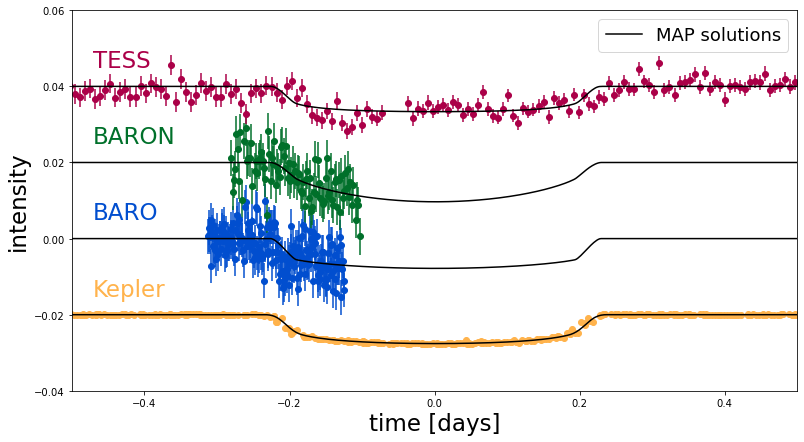

In [24]:
dt = np.linspace(-.5, .5, 500)

with model:
    for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
        phase_curves = pmx.eval_in_model(
                [lc_models[k](t0s[0] + dt) for k in datasets], map_soln)

index = 0
colors = ["#ffb34c", "#014ecf", "#00702a", "#ab0048"]
plt.figure(figsize = [13,7])
shift = -0.02
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    # Get the posterior median orbital parameters
    p = 160.883
    t0 = 2851.641


    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y+shift, yerr=yerr, marker='o', ls='', color=colors[index], zorder=-1000
    )
    plt.plot(dt, phase_curves[index]+shift, color='k', ms=4, label='MAP solutions')

    
    
    plt.annotate(name, 
                 xy=(-0.47, shift+.005),  
                 xycoords='data',
                 textcoords='offset points',
                 fontsize = 23,
                 color=colors[index])


    
    index+=1
    shift+=.02
    
    
plt.xlim(-0.5, 0.5)
plt.ylim(-0.04, 0.06)
plt.ylabel("intensity", fontsize = 23)
plt.xlabel("time [days]", fontsize = 23)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=18, loc=1)
#plt.savefig('map_soln_dec15.pdf')
    

plt.show()